In [1]:
import networkx as nx
import numpy as np
import string
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
import pickle

In [2]:
# city = 'Utrecht'
# city_str = 'Utrecht, Netherlands'
# dist = 6500

# city = 'Winterswijk'
# city_str = 'Winterswijk, Netherlands'
# dist = 10000

# city = 'Manhattan'
# city_str = 'Union Square, New York, United States'
# dist = 5000

# city = 'Amsterdam'
# city_str = 'Meeuwenlaan 88, Amsterdam, Netherlands'
# dist = 15000

city = 'Rotterdam'
city_str = 'Rotterdam, Netherlands'
dist = 8000
locations = ['centre','port']

In [3]:
filepath=f"graphs/{city}.graph.graphml"
# ox.save_graph_geopackage(G, filepath=filepath)
G = ox.load_graphml(filepath=filepath)

with open(f'data/escape_nodes_{city}.pkl', 'rb') as f:
    escape_nodes = pickle.load(f)

for location in locations:
    with open(f'data/fugitive_start_{city}_{location}.pkl', 'rb') as f:
        fugitive_start = pickle.load(f)

if city != 'Winterswijk':    
    with open(f'data/cameras_{city}.pkl', 'rb') as f:
        cameras = pickle.load(f)
elif city == 'Winterswijk':
    cameras = []

In [4]:
len(escape_nodes)

150

In [5]:
escape_nodes_filtered = []
for escape_node in escape_nodes:
    if G.has_node(escape_node):
        escape_nodes_filtered.append(escape_node)

with open('data/escape_nodes_{city}_filtered.pkl', 'wb') as f:
    pickle.dump(escape_nodes_filtered, f)

In [6]:
escape_nodes = escape_nodes_filtered.copy()
len(escape_nodes_filtered)

112

In [34]:
def draw_edges(graph):
    edges_fugitive = []

    # for i_r, route_time in enumerate(fugitive_routes):
    #     route = list(route_time.values())
    #     for i, node in enumerate(route):
    #         if i ==0:
    #             continue
    #         else:
    #             edges_fugitive1 = [(route[i], route[i-1])]
    #             edges_fugitive2 = [(route[i-1], route[i])]
    #             edges_fugitive.extend(tuple(edges_fugitive1))
    #             edges_fugitive.extend(tuple(edges_fugitive2))

    edge_colormap = ['lightgray'] * len(graph.edges())
    edge_weightmap = [1] * len(graph.edges())
    for index, edge in enumerate(graph.edges()):
        if edge in edges_fugitive:
            edge_colormap[index] = 'tab:orange'
            edge_weightmap[index] = 2

    return edge_colormap, edge_weightmap

In [7]:
with open('data/fugitive_start_Rotterdam_centre.pkl', 'rb') as f:
    fugitive_start_centre = pickle.load(f)

with open('data/fugitive_start_Rotterdam_port.pkl', 'rb') as f:
    fugitive_start_port = pickle.load(f)

fugitive_starts = [
    ('centre', fugitive_start_centre),
    ('port', fugitive_start_port)
]

def draw_nodes(G, fugitive_start, cameras, trafficlights, roundabouts, tunnels, bridges, escape_nodes):
    node_size = []
    node_color = []
    for node in G.nodes:
        if node == fugitive_start:
            node_size.append(40)
            node_color.append('tab:orange')
        elif node in escape_nodes:
            node_size.append(40)
            node_color.append('tab:red')
        elif node in trafficlights:
            node_size.append(10)
            node_color.append('purple')  
        elif node in cameras:
            node_size.append(10)
            node_color.append('tab:green')      
  
        elif node in roundabouts:
            node_size.append(10)
            node_color.append('gold')    
        elif node in tunnels:
            node_size.append(10)
            node_color.append('aqua')   
        elif node in bridges:
            node_size.append(10)
            node_color.append('royalblue')   
        else:
            node_size.append(0)
            node_color.append('lightgray')
    return node_size, node_color

In [36]:
from matplotlib.lines import Line2D

def show_graph(G, escape_nodes, fugitive_start, cameras, trafficlights, roundabouts, bridges, tunnels, location_name, save=False):
    # filepath=f"graphs/FLEE/Graph_FLEE.graph.graphml"
    # G = ox.load_graphml(filepath=filepath)

    edge_colormap, edge_weightmap = draw_edges(G)
    node_size, node_color = draw_nodes(G, fugitive_start, cameras, trafficlights, roundabouts, tunnels, bridges, escape_nodes)

    fig, ax = ox.plot_graph(
                G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                )
    if save:

        custom_lines = [Line2D([0], [0], color='tab:orange', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='tab:red', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='tab:green', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='purple', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='gold', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='aqua', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='royalblue', marker='o', markersize=10, linestyle=''),
                        ]
        labels = ['start fugitive', 'escape node', 'camera', 'traffic light', 'roundabout', 'tunnel', 'bridge']
        ax.legend(custom_lines, labels, bbox_to_anchor=(1.1, 1.05))
        fig.savefig(f'graphs/{city}_features.png', bbox_inches='tight', dpi=300)

In [8]:
roundabouts = []
for u,v, data in G.edges(data=True): 
    if 'junction' in data.keys():
        if data['junction'] == 'roundabout':
            roundabouts.append(u)
            roundabouts.append(v)
            
roundabouts = np.unique(roundabouts)

In [9]:
with open(f'./model_elements/roundabouts.pkl', 'wb') as f:
    pickle.dump(roundabouts, f)

In [10]:
#On roundabouts, the maximum speed is not a realistic speed to drive. So, for 50km/h roundabouts, a speed of 30 is set, and roundabouts of 80km/h a speed of 50km/h will be used

#Only when withtraffic is wanted, otherwise comment this cell out (change manually)

for u, v, data in G.edges(data=True):
    if 'maxspeed' in data:
        if u in roundabouts and v in roundabouts:
            if data['maxspeed'] == 50:
                data['maxspeed'] = 30
                data['speed_kph'] = 30
            if data['maxspeed'] == 80:
                data['maxspeed'] = 50
                data['speed_kph'] = 50

In [11]:
import networkx as nx
import osmnx as ox

# TODO exclude traffic lights that are too far from their real loc

useful_tags_path = ['bridge', 'tunnel', 'oneway', 'lanes', 'ref', 'name', 'length',
                    'highway', 'maxspeed', 'service', 'access', 'area', 'name'
                    'landuse', 'width', 'est_width', 'junction', 'surface', 
                    'traffic_signals', 'crossing']

ox.settings.useful_tags_way=useful_tags_path

def generate_streetnetwork(city_str, dist):
    """
    Load a network from OSMNX which will be used for the simulation runs. The generated network is from Rotterdam.
    Returns
    -------
    G: network MultiGraph
        Network Graph with different attributes:
            Nodes and Edges with LineString with coordinates,
            Edges have properties Speed, Travel time, Length.

    """
   
    cf = '["highway"~"motorway|motorway_link|trunk|trunk_link|primary|secondary|tertiary|residential|unclassified"]' #busway
    
    ox.settings.log_console=True
    ox.settings.use_cache=True

    # download street network data from OSM and construct a MultiDiGraph model
    G = ox.graph_from_address(city_str, dist=dist, network_type='drive', simplify=False, custom_filter=cf)

    return G

G_notsimplified=generate_streetnetwork(city_str, dist)

In [12]:
if city == 'Manhattan':
    G_notsimplified = G.copy()

trafficlight_locs = []
for u, data in G_notsimplified.nodes(data=True):
    if 'traffic_signals' in data.keys():
        trafficlight_locs.append(data)
    elif 'highway' in data.keys():
        if data['highway'] == 'traffic_signals':
            trafficlight_locs.append(data)
    elif 'crossing' in data.keys():
        if data['crossing'] == 'traffic_signals':
            trafficlight_locs.append(data)

In [13]:
import osmnx as ox
import numpy as np

trafficlights = []

# Loop door elk element in de lijst trafficlight_locs
for trafficlight_loc in trafficlight_locs:
    # Haal de y- en x-coördinaten uit elk element
    y_coord = trafficlight_loc['y']
    x_coord = trafficlight_loc['x']

    # Bereken de afstand tussen elk knooppunt en de gegeven coördinaten
    node_distances = {}
    for node in G.nodes():
        if 'x' in G.nodes[node] and 'y' in G.nodes[node]:
            node_y = G.nodes[node]['y']
            node_x = G.nodes[node]['x']
            distance = np.sqrt((y_coord - node_y)**2 + (x_coord - node_x)**2)
            node_distances[node] = distance

    nearest_node = min(node_distances, key=node_distances.get)
    trafficlights.append(nearest_node)

trafficlights = np.unique(trafficlights)

In [43]:
#len(trafficlights)

In [14]:
tunnels = []
for u, v, data in G.edges(data=True): 
    if 'tunnel' in data.keys():
        tunnels.append(u)
        tunnels.append(v)
            
tunnels = np.unique(tunnels)

In [23]:
# bridges = []
# for u, v, data in G.edges(data=True):
#     if 'bridge' in data.keys():
#         if data['bridge'] == 'movable':
#             bridges.append(u)
#             bridges.append(v)
#
# bridges = np.unique(bridges)
# bridges

In [15]:
bridges1 = []
for u, v, data in G.edges(data=True):
    if 'bridge' in data.keys():
        if data['bridge'] == 'movable':
            bridges1.append(u)
            bridges1.append(v)

bridges1 = np.unique(bridges1)

In [16]:
import pandas as pd
from pandas.io.json import json_normalize
import json

bridges_path = f'./data/bridges_rotterdam.json'
with open(bridges_path, 'r') as json_bestand:
    data = json.load(json_bestand)

# converteer json bestand naar een DataFrame
bridges_dataframe = json_normalize(data)

bridges_dataframe = bridges_dataframe[bridges_dataframe['type']=='node']
bridges_dataframe = bridges_dataframe[['id','lat','lon']]

C:\Users\Veerle\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


In [17]:
bridges = []
for i in bridges_dataframe:
    dichtstbijzijnde_node = ox.nearest_nodes(G, bridges_dataframe['lon'], bridges_dataframe['lat'])
    bridges.append(dichtstbijzijnde_node)
bridges = np.unique(bridges)

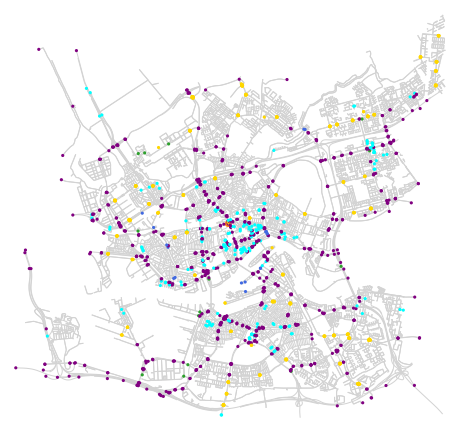

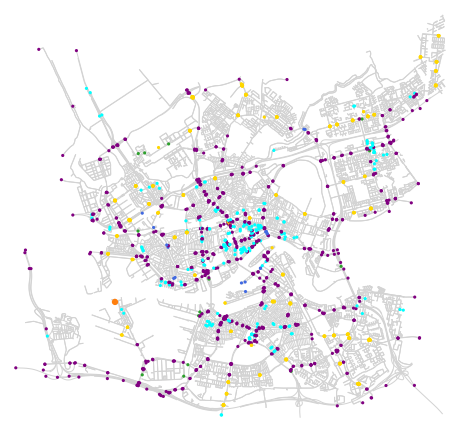

In [48]:
for location_name, fugitive_start in fugitive_starts:
    #show_graph(G, escape_nodes, fugitive_start, [], [], [], [], [], location_name, save=True)
    show_graph(G, [], fugitive_start, cameras, trafficlights, roundabouts, bridges, tunnels, location_name, save=True)

Congestion factor

In [18]:
#give each edge a congestion factor
congestion_travel_time_dict = {}
for u, v, z, data in G.edges(data=True, keys=True):
    if data['highway'] in ['trunk', 'primary']:
        congestion_factor = 1.75
    elif data['highway'] in ['motorway']:
        congestion_factor = 2
    elif data['highway'] in ['secondary']:
        congestion_factor = 1.5
    elif data['highway'] in ['tertiary']:
        congestion_factor = 1.25
    else:
        congestion_factor = 1

    data['congestion_factor'] = congestion_factor
    travel_time_with_congestion = float(data['travel_time'] * data['congestion_factor'])

    congestion_travel_time_dict[(u, v, z)] = travel_time_with_congestion

for u, v, z, data in G.edges(data=True, keys=True):
    if 'lanes' in data:
        if data['lanes'] == '1' and data['highway'] in ['trunk', 'primary', 'secondary']:
            data['congestion_factor'] += 0.2
            travel_time_with_congestion = float(data['travel_time'] * data['congestion_factor'])
            congestion_travel_time_dict[(u, v, z)] = travel_time_with_congestion

nx.set_edge_attributes(G, congestion_travel_time_dict, "travel_time_with_congestion")

Loop through all edges in graph. If u/v has camera/traffic light/roundabout/etc, add time to travel_time of edge. e.g. 30 sec for camera, 10 sec for traffic light, 5 for roundabout (bc multiple nodes)?

In [19]:
camera_extra_time = 0
roundabout_extra_time = 5
trafficlight_extra_time = 30
tunnel_extra_time = 15
bridge_extra_time = 10

travel_time_dict = {}
for u, v, z, data in G.edges(data=True,keys=True):
    travel_time_adj = data['travel_time_with_congestion'] #of travel_time_with_congestion
    
    # number of lanes
    if 'lanes' in data.keys():
        if '1' in data['lanes']:
            travel_time_adj += data['travel_time_with_congestion'] * 0.2
        elif '2' in data['lanes']:
            pass
        else:
            travel_time_adj -= data['travel_time_with_congestion'] * 0.2
        
    # speed limit
    if data['speed_kph'] <= 30:
        travel_time_adj += data['travel_time_with_congestion'] * 0.2
    elif data['speed_kph'] <= 50:
        pass
    elif data['speed_kph'] <= 80:
        travel_time_adj -= data['travel_time_with_congestion'] * 0.1
    elif data['speed_kph'] >= 80:
        travel_time_adj -= data['travel_time_with_congestion'] * 0.2
    
    if data['highway'] in ['motorway', 'trunk', 'primary']: 
        travel_time_adj += 40
    
    if u in cameras:
        travel_time_adj += camera_extra_time
    if u in trafficlights:
        travel_time_adj += trafficlight_extra_time
    if u in roundabouts:
        travel_time_adj += roundabout_extra_time
    if u in tunnels:
        travel_time_adj += tunnel_extra_time
    if u in bridges:
        travel_time_adj += bridge_extra_time
    
    if v in cameras:
        travel_time_adj += camera_extra_time
    if v in trafficlights:
        travel_time_adj += trafficlight_extra_time
    if v in roundabouts:
        travel_time_adj += roundabout_extra_time
    if v in tunnels:
        travel_time_adj += tunnel_extra_time
    if v in bridges:
        travel_time_adj += bridge_extra_time
    
    travel_time_dict[(u, v, z)] = float(travel_time_adj)

nx.set_edge_attributes(G, travel_time_dict, "travel_time_adj")

In [258]:
# escape_routes = []
# for escape_node in escape_nodes: 
#     try:
#         path = nx.shortest_path(G, fugitive_start, escape_node, 'travel_time_adj')
#         # [escape_routes.append(path) for path in nx.all_simple_paths(G, fugitive_start, escape_node)]
#         escape_routes.append(path)
#     except:
#         continue

In [74]:
len(escape_nodes)

112

In [20]:
for location_name, fugitive_start in fugitive_starts:
    route_fugitive = []
    while len(route_fugitive) < 1000:
        for escape_node in escape_nodes_filtered:
            try:
                path = nx.shortest_path(G, fugitive_start, escape_node, 'travel_time_adj')
                route_fugitive.append(path)
            except:
                continue

#save accordingly (change manually)
    with open(f'data/escape_routes_Rotterdam_hot_{location_name}_withtraffic.pkl', 'wb') as f:
        pickle.dump(route_fugitive, f)

In [52]:
len(route_fugitive)

1008

## put shortest path into ABM and add noise where they deviate from shortest path

In [212]:
# jitter = 0.02
# 
# # nx.draw_networkx_edges(G,edgelist=path_edges,edge_color='r',width=10)
# node_size, node_color = draw_nodes(G, fugitive_start, cameras, trafficlights, roundabouts, tunnels, bridges, escape_nodes)
# edge_colormap, edge_weightmap = draw_edges(G)
# 
# with open(f'data/results_routes_{city}_jitter{jitter}.pkl', 'rb') as f:
#     results_routes = pickle.load(f)
# 
# results_routes = [list(route.values()) for route in results_routes]
# 
# fig, ax = ox.plot_graph_routes(G, results_routes, 
#                                route_linewidths=1, route_alpha=0.05,
#                                edge_linewidth=edge_weightmap, edge_color=edge_colormap,
#                                node_color=node_color, node_size=node_size, 
#                                bgcolor="white", 
#                                orig_dest_size=30,
#                                # orig_dest_node_color=['tab:orange', 'tab:red']*len(results_routes),
#                                )
# 
# fig.savefig(f'{city}_cool_noise_jitter{jitter}.png', bbox_inches='tight', dpi=300)
# #add ANPR cameras

Graaf die sommige edges niet heeft omdat ze zijn uitgevallen door brugopening/ongeluk (=onvoorziene omstandigheden)

In [33]:
#maak een nieuwe graaf, waar bepaalde edges uit verwijderd worden
G_nietalleedges = G.copy()
edges_onvoorzieneomstandigheid = []
nodes_onvoorzieneomstandigheid = []
for u,v,data in G_nietalleedges.edges(data=True):
    if 'name' in data:
        #een ongeluk komt voor op de centrale primaire Statenweg, waardoor deze weg ontoegankelijk wordt
        if data['name'] == 'Statenweg' and data['highway']=='primary':
            edges_onvoorzieneomstandigheid.append((u,v))
            nodes_onvoorzieneomstandigheid.append(u)
            nodes_onvoorzieneomstandigheid.append(v)
        #de Willem Buytewechstraat gaat over de Coolhavenbrug, die gekozen is om te openen
        if data['name'] == 'Willem Buytewechstraat':
            edges_onvoorzieneomstandigheid.append((u,v))
            nodes_onvoorzieneomstandigheid.append(u)
            nodes_onvoorzieneomstandigheid.append(v)
        #de weg die over de Parkhavenbrug gaat heet Westzeedijk
        if data['name'] == 'Westzeedijk':
            edges_onvoorzieneomstandigheid.append((u,v))
            nodes_onvoorzieneomstandigheid.append(u)
            nodes_onvoorzieneomstandigheid.append(v)

G_nietalleedges.remove_edges_from(edges_onvoorzieneomstandigheid)

In [ ]:
filepath=f"./graphs/{city}_notalledges_prepped.graph.graphml"
ox.save_graphml(G_nietalleedges,filepath)

with open(f'model_elements/afgeslotenwegen.pkl', 'wb') as f:
    pickle.dump(nodes_onvoorzieneomstandigheid, f)

Politie informatie inlezen

In [21]:
#politiebureau nodes inlezen voor Rotterdam, ik heb gekozen voor 6 bureaus, in centrum, oost, noord, 2 in zuid en maashaven
locations2 = [(4.48020, 51.92399), (4.49594, 51.90196)]
locations4 = [(4.49594, 51.90196), (4.48020, 51.92399), (4.55229, 51.94875), (4.482000, 51.8756)]

def save_police_data(locations, number_units):
    politie_bureau = []
    delay = []
    for location in locations:
        dichtstbijzijnde_node = ox.nearest_nodes(G, location[0], location[1])
        politie_bureau.append(dichtstbijzijnde_node)
        delay.append(0)

    with open(f'./data/optimization/start_police_{city}_{number_units}.pkl', 'wb') as f:
        pickle.dump(politie_bureau, f)

    with open(f'./data/optimization/delays_police_{city}_{number_units}.pkl', 'wb') as f:
        pickle.dump(delay, f)

save_police_data(locations2, '2')
save_police_data(locations4, '4')

In [22]:
police_travel_time_dict = {}
for u, v, z, data in G.edges(data=True, keys=True):
    police_travel_time_dict[(u, v, z)] = data['travel_time']

for u, v, z, data in G.edges(data=True,keys=True):
    if 'lanes' in data:
        if data['lanes'] == 1:
            police_travel_time = data['travel_time']/1.1
            police_travel_time_dict[(u, v, z)] = float(police_travel_time)
        else:
            police_travel_time = data['travel_time']/1.3
            police_travel_time_dict[(u, v, z)] = float(police_travel_time)

nx.set_edge_attributes(G, police_travel_time_dict, "police_travel_time")

police_travel_time_dict_traffic = {}
for u, v, z, data in G.edges(data=True, keys=True):
    police_travel_time_dict_traffic[(u, v, z)] = data['travel_time']

for u, v, z, data in G.edges(data=True,keys=True):
    if 'lanes' in data:
        if data['lanes'] == 1:
            police_travel_time_traffic = data['travel_time_with_congestion']/1.1
            police_travel_time_dict_traffic[(u, v, z)] = float(police_travel_time_traffic)
    else:
        police_travel_time_traffic = data['travel_time_with_congestion']/1.3
        police_travel_time_dict_traffic[(u, v, z)] = float(police_travel_time_traffic)

nx.set_edge_attributes(G, police_travel_time_dict_traffic, "police_travel_time_traffic")

police_travel_time_dict_eval = {}
for u, v, z, data in G.edges(data=True, keys=True):
    police_travel_time_dict_eval[(u, v, z)] = data['travel_time']

for u, v, z, data in G.edges(data=True,keys=True):
    if 'police_travel_time_traffic' in data and 'police_travel_time' in data:
        police_travel_time_eval = (data['police_travel_time'] + data['police_travel_time_traffic'])/2
        police_travel_time_dict_eval[(u, v, z)] = float(police_travel_time_eval)
    elif 'police_travel_time_traffic' in data:
        police_travel_time_eval = data['police_travel_time_traffic']
        police_travel_time_dict_eval[(u, v, z)] = float(police_travel_time_eval)
    elif 'police_travel_time' in data:
        police_travel_time_eval = data['police_travel_time']
        police_travel_time_dict_eval[(u, v, z)] = float(police_travel_time_eval)
    else:
        police_travel_time_eval = data['travel_time']
        police_travel_time_dict_eval[(u, v, z)] = float(police_travel_time_eval)

nx.set_edge_attributes(G, police_travel_time_dict_eval, "police_travel_time_eval")

In [23]:
#change name to the according situation (change manually)
filepath=f"./graphs/{city}_withtraffic_prepped_hot.graph.graphml"
# ox.save_graph_geopackage(G, filepath=filepath)
ox.save_graphml(G,filepath)

Trafficlight categories

In [37]:
primary_trafficlight_nodes = []

for node in G_notsimplified.nodes():
    if all(data['highway'] == 'primary' or data['highway'] == 'trunk' for _, _, data in G_notsimplified.edges(node, data=True)):
        if node in trafficlights:
            primary_trafficlight_nodes.append(node)

# Verwijder duplicaten uit de lijst
primary_trafficlight_nodes = list(set(primary_trafficlight_nodes))

In [38]:
primarysecondary_trafficlight_nodes = []

for node in G_notsimplified.nodes():
    primary_found = False
    secondary_found = False

    for _, _, data in G_notsimplified.edges(node, data=True):
        # Controleer of er een weg van het type 'primary' of 'trunk' aansluit op de node
        if data.get('highway') in ['primary', 'trunk']:
            primary_found = True
        # Controleer of er een weg van het type 'secondary' aansluit op de node
        elif data.get('highway') == 'secondary':
            secondary_found = True

    # Voeg de node toe aan de lijst als zowel een 'primary' of 'trunk' weg als een 'secondary' weg aansluiten en er een verkeerslicht op de node is
    if primary_found and secondary_found and node in trafficlights:
        primarysecondary_trafficlight_nodes.append(node)

# Verwijder duplicaten uit de lijst
primarysecondary_trafficlight_nodes = list(set(primarysecondary_trafficlight_nodes))

In [39]:
primarytertiary_trafficlight_nodes = []

for node in G_notsimplified.nodes():
    primary_found = False
    tertiary_found = False

    for _, _, data in G_notsimplified.edges(node, data=True):
        if data.get('highway') in ['primary', 'trunk']:
            primary_found = True
        elif data.get('highway') == 'tertiary':
            tertiary_found = True

    if primary_found and tertiary_found and node in trafficlights:
        primarytertiary_trafficlight_nodes.append(node)

# Verwijder duplicaten uit de lijst
primarytertiary_trafficlight_nodes = list(set(primarytertiary_trafficlight_nodes))

In [40]:
primaryresidential_trafficlight_nodes = []

for node in G_notsimplified.nodes():
    residential_found = False
    primary_found = False

    for _, _, data in G_notsimplified.edges(node, data=True):
        if data.get('highway') == 'residential':
            residential_found = True
        elif data.get('highway') == 'primary':
            primary_found = True

    if residential_found and primary_found and node in trafficlights:
        primaryresidential_trafficlight_nodes.append(node)

primaryresidential_trafficlight_nodes = list(set(primaryresidential_trafficlight_nodes))

With tram

In [41]:
useful_tags_path = ['bridge', 'tunnel', 'oneway', 'lanes', 'ref', 'name', 'length',
                    'highway', 'maxspeed', 'service', 'access', 'area', 'name',
                    'landuse', 'width', 'est_width', 'junction', 'surface',
                    'traffic_signals', 'crossing', 'railway',
                    'railway=tram', 'tram=yes', 'tram:lanes=*',
                    'highway=busway']


ox.settings.useful_tags_way=useful_tags_path

def generate_tramnetwork():

    """
    Load a network from OSMNX which will be used for the simulation runs. The generated network is from Rotterdam.
    Returns
    -------
    G: network MultiGraph
        Network Graph with different attributes:
            Nodes and Edges with LineString with coordinates,
            Edges have properties Speed, Travel time, Length.

    """
    lonlat=     'Netherlands'                                 #coordinates of the city centre of Rotterdam
    roadtype=   "drive"                                     #select only roads which are driveable by the car.

    railway_filter = '["railway"~"tram"]'


    ox.settings.log_console=True
    ox.settings.use_cache=True
    # ox.config(use_cache=True, log_console=True)

    # download street network data from OSM and construct a MultiDiGraph model
   #G = ox.graph_from_address('Rotterdam, Netherlands', dist=8000, network_type='drive', simplify=True, custom_filter=cf)
    #T = ox.graph_from_bbox(51.9248, 51.8048, 4.4699, 4.5899, simplify=True, custom_filter=railway_filter)
    T = ox.graph_from_address('Rotterdam, Netherlands', dist=8000, simplify=True, custom_filter=railway_filter)


    return T

In [42]:
T=generate_tramnetwork()

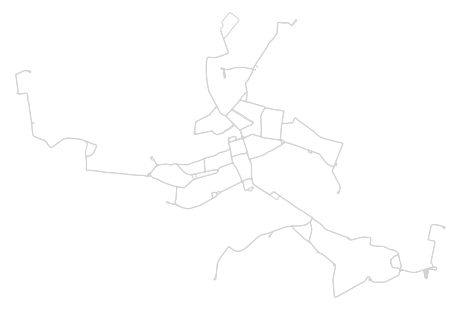

In [43]:
#Tramlijnen tekenen
fig, ax = ox.plot_graph(
   T, bgcolor="white", node_color="lightgray", node_size=1, edge_linewidth=1, edge_color="lightgray",
   save=False)

In [44]:
def get_node_coordinates(graph):
    coordinates = []
    for node, data in graph.nodes(data=True):
        coord = (data['y'], data['x'])
        coordinates.append(coord)
    return coordinates

node_coordinates = get_node_coordinates(T)

tram_nodes = []
for coord in node_coordinates:
    nearest_node = ox.nearest_nodes(G, coord[1], coord[0])
    tram_nodes.append(nearest_node)

In [45]:
intersection_with_tram = []
for node in tram_nodes:
    if node in trafficlights:
        intersection_with_tram.append(node)
#intersection_with_tram

In [46]:
with open(f'./model_elements/intersection_withtram.pkl', 'wb') as f:
    pickle.dump(intersection_with_tram, f)

Green wave

In [47]:
traffic_lights_within_150m = []

# Itereer over elk paar stoplichten en controleer of er een kort pad is binnen 150 meter
for source in primary_trafficlight_nodes or primarysecondary_trafficlight_nodes or primarytertiary_trafficlight_nodes or primaryresidential_trafficlight_nodes:
    for target in primary_trafficlight_nodes or primarysecondary_trafficlight_nodes or primarytertiary_trafficlight_nodes or primaryresidential_trafficlight_nodes:
        if source != target and nx.has_path(G, source=source, target=target):
            path_length = nx.shortest_path_length(G, source=source, target=target, weight='travel_time')
            if path_length < 150:
                traffic_lights_within_150m.append(source)
                break  # Omdat we alleen willen weten of er een kort pad is, kunnen we stoppen met zoeken naar andere stoplichten

[1435028993, 44366722, 4893441413, 5313487237, 44344078, 44344079, 1027160470, 44378905, 2098302884, 4336525732, 1027160486, 44152359, 670388777, 44492717, 4541858605, 44496951, 1027160502, 44153532, 44391752, 1687745613, 44374993, 44495574, 1465648217, 582730460, 44341341, 987492067, 44454500, 768903396, 582730470, 1555848039, 1964247528, 3428185955, 3428185957, 3428185961, 11822895716, 3428185965, 4893350894, 582730483, 11230989181]


In [48]:
with open(f'./model_elements/green_wave.pkl', 'wb') as f:
    pickle.dump(traffic_lights_within_150m, f)

In [49]:
green_wave_road = []
cross_green_wave_road = []
for u,v,data in G.edges(data=True):
    if 'highway' in data.keys():
        if data['highway']=='primary' or data['highway']=='trunk':
            if u in traffic_lights_within_150m and v in traffic_lights_within_150m:
                green_wave_road.append([u,v])
        elif v in traffic_lights_within_150m:
            cross_green_wave_road.append([u,v])


In [50]:
with open(f'./model_elements/green_wave_road.pkl', 'wb') as f:
    pickle.dump(green_wave_road, f)

with open(f'./model_elements/cross_green_wave_road.pkl', 'wb') as f:
    pickle.dump(cross_green_wave_road, f)

Default category

In [51]:
default = []

for node in trafficlights:
    # Controleer of de node niet in een van de andere lijsten zit
    if node not in intersection_with_tram and node not in traffic_lights_within_150m:
        default.append(node)

with open(f'./model_elements/default.pkl', 'wb') as f:
    pickle.dump(default, f)


In [52]:
traffic_light_categories = {}

def add_nodes_to_dict(nodes, list_name):
    for node in nodes:
        if isinstance(node, (str, int, float, tuple, int, np.integer)):  # Controleren op valide datatypes inclusief numpy
            traffic_light_categories[node] = list_name
        elif isinstance(node, list) and all(isinstance(item, (str, int, float, tuple, np.integer)) for item in node):
            traffic_light_categories[tuple(node)] = list_name  # Converteer lijst naar tuple
        else:
            print(f"Skipping invalid node {node} in list {list_name}, type {type(node)}")

add_nodes_to_dict(intersection_with_tram, 'intersection_with_tram')
add_nodes_to_dict(default, 'default')
add_nodes_to_dict(traffic_lights_within_150m, 'green_wave')
# add_nodes_to_dict(cross_green_wave_road, 'cross_green_wave')
# add_nodes_to_dict(green_wave_road, 'green_wave')

print(traffic_light_categories)
with open(f'./model_elements/traffic_light_categories.pkl', 'wb') as f:
    pickle.dump(traffic_light_categories, f)

{1030572746: 'intersection_with_tram', 1445795627: 'intersection_with_tram', 1426610337: 'intersection_with_tram', 597440929: 'intersection_with_tram', 603233348: 'intersection_with_tram', 1552938954: 'intersection_with_tram', 44326564: 'intersection_with_tram', 558864428: 'intersection_with_tram', 1435580541: 'intersection_with_tram', 44378905: 'green_wave', 582730470: 'green_wave', 1435028993: 'green_wave', 44342670: 'intersection_with_tram', 44341341: 'green_wave', 1426610335: 'intersection_with_tram', 44225957: 'intersection_with_tram', 1435580552: 'intersection_with_tram', 1435580737: 'intersection_with_tram', 582611814: 'intersection_with_tram', 6486507707: 'intersection_with_tram', 322070776: 'intersection_with_tram', 11834957298: 'intersection_with_tram', 2462046181: 'intersection_with_tram', 322058115: 'intersection_with_tram', 1687745613: 'green_wave', 1612095282: 'intersection_with_tram', 2178103146: 'intersection_with_tram', 44411338: 'intersection_with_tram', 4691536387: '